# Finding the min-norm solution to a linear system of equations.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cooper-org/cooper/blob/master/docs/source/notebooks/plot_min_norm.ipynb)


This example considers the problem of finding the min-L2-norm solution to a system of
linear equations. The problem is formulated as a constrained minimization problem:

$$
\min_{x}  \,\, \Vert x \Vert_2^2  \,\, s.t. \,\, Ax = b
$$

where $A$ is a matrix of size $(m, n)$ and $b$ is a vector of size
$(m, 1)$.

This is a well-known convex problem in numerical linear algebra, whose solution is given
by the vector $x^*$ satisfying $A^{\dagger}b = x^*$, where
$A^{\dagger}$ is the Moore-Penrose pseudo-inverse of $A$.

Here we analyze this traditional problem under the framework of gradient-based
Lagrangian optimization. We allow for the possibility that the system of equations
is partially observed at each iteration. That is, we assume that the matrix $A$
and the vector $b$ may be sub-sampled at each iteration.

$$
\mathcal{L}(x, \lambda) = \Vert x \Vert_2^2 + \lambda^T D (Ax - b)
$$

where $\lambda$ is the vector of Lagrange multipliers, and $D$ is a
stochastic diagonal matrix with $1$ on the indices corresponding to the observed
equations and $0$ everywhere else.

The results below illustrate the influence of the number of observed equations on the
convergence of the algorithm.

In [1]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

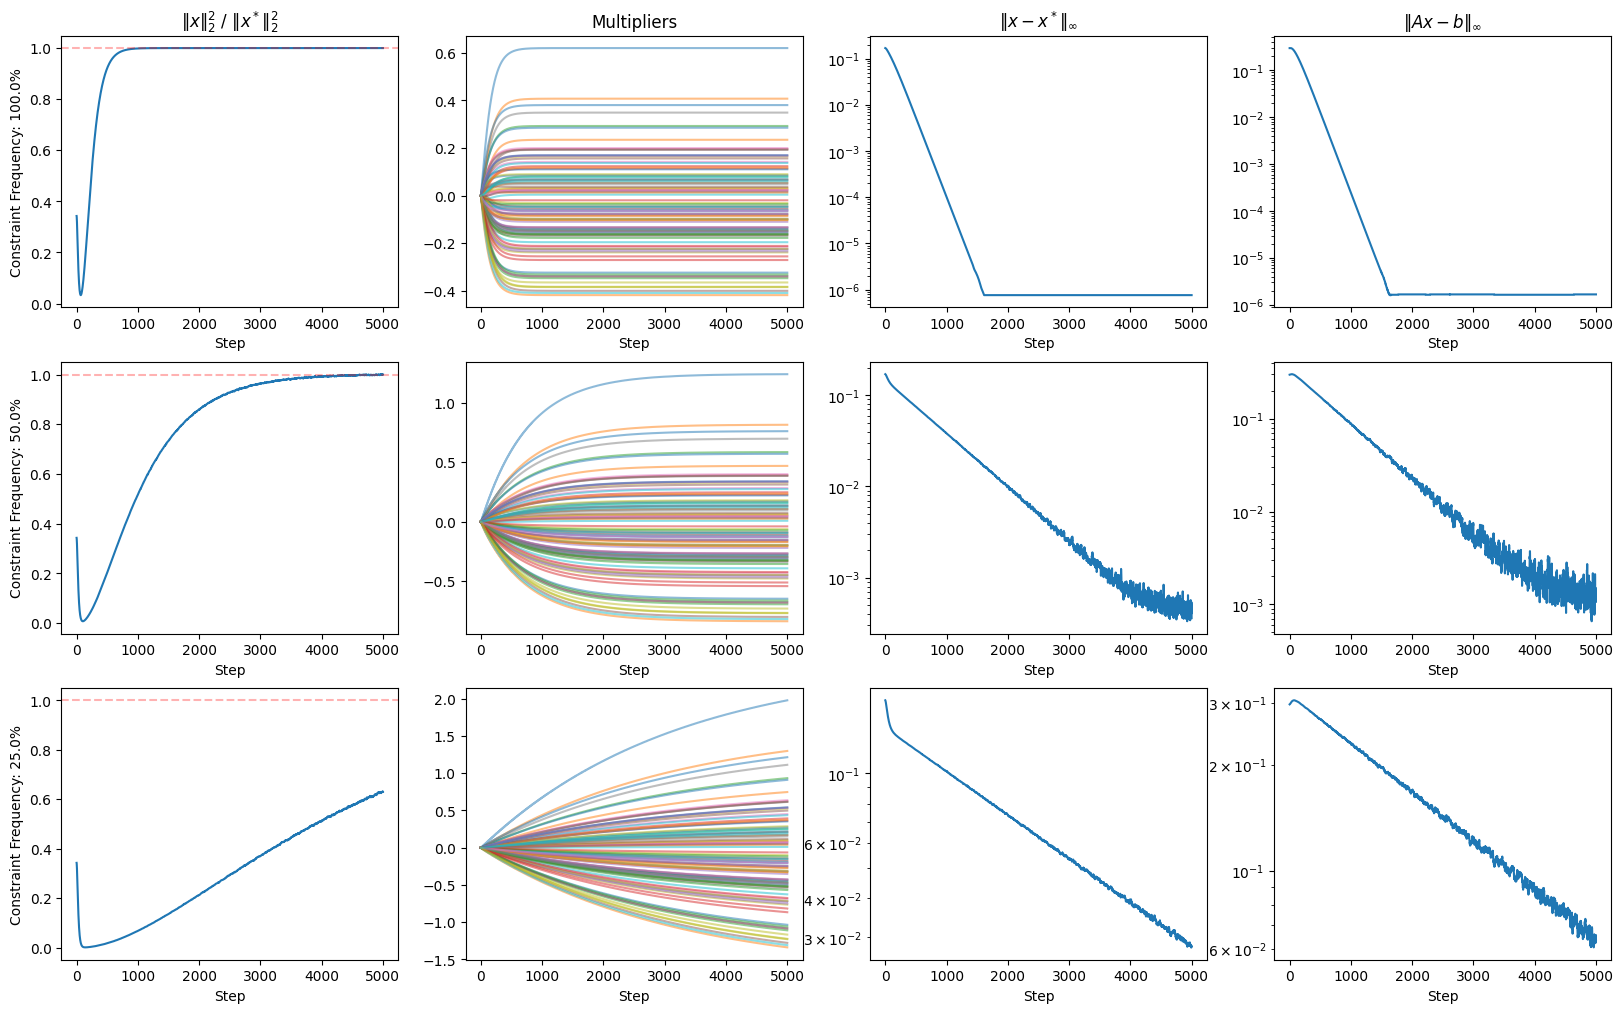

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import BatchSampler, RandomSampler

import cooper

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def create_linear_system(num_equations: int, num_variable: int, seed: int = 0):
    """Create a solvable linear system with a well-behaved matrix spectrum.

    Args:
        num_equations: Number of equations in the linear system.
        num_variable: Number of variables in the linear system.
        seed: The seed value to set for random number generation.
    """
    torch.manual_seed(seed=seed)

    # Create a random linear system with 1-singular values
    U, _, V = torch.linalg.svd(torch.randn(num_equations, num_variable))
    S = torch.eye(num_equations, num_variable)
    A = U @ S @ V.T

    # Build a solvable linear system
    b = A @ torch.randn(num_variable, 1)
    b /= torch.linalg.vector_norm(b)

    # Build min-norm solution based on the SVD of A
    x_optim = V @ (S.T @ (U.T @ b))

    # Verify that the analytical solution is sufficiently close numerically
    assert torch.allclose(A @ x_optim, b, atol=1e-5)

    A, b, x_optim = A.to(DEVICE), b.to(DEVICE), x_optim.to(DEVICE)

    return A, b, x_optim


class LinearConstraintDataset(Dataset):
    """Dataset comprising equations in a linear constraint system. This dataset is used
    to sample equations for the equality constraints in the min-norm problem.

    Args:
        A: Matrix of the linear system.
        b: Right-hand side of the linear system.
    """

    def __init__(self, A: torch.Tensor, b: torch.Tensor):
        self.A, self.b = A, b

    def __len__(self):
        return self.A.shape[0]

    def __getitem__(self, index: list[int]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        index = torch.tensor(index)
        return self.A[index], self.b[index], index


def instantiate_dataloader(dataset: Dataset, batch_size: int, seed=0) -> DataLoader:
    # Create a dataloader that samples uniformly with replacement. Pass a generator and a
    # worker_init_fn to ensure reproducibility
    g = torch.Generator()
    g.manual_seed(seed)

    # Create a random sampler and a batch sampler to sample the constraints uniformly with replacement
    random_sampler = RandomSampler(dataset, replacement=False, generator=g)
    batch_sampler = BatchSampler(random_sampler, batch_size=batch_size, drop_last=True)

    return DataLoader(dataset, sampler=batch_sampler, batch_size=None)


class MinNormWithLinearConstraints(cooper.ConstrainedMinimizationProblem):
    """Min-norm problem with linear equality constraints."""

    def __init__(self, num_equations: int) -> None:
        super().__init__()
        # Create a constraint for the equality constraints. We use a sparse constraint
        # to be able to update the multipliers only with the observed constraints (i.e. the
        # ones that are active in the current batch)
        constraint_type = cooper.ConstraintType.EQUALITY
        multiplier = cooper.multipliers.IndexedMultiplier(num_constraints=num_equations, device=DEVICE)
        self.eq_constraint = cooper.Constraint(
            constraint_type=constraint_type, formulation_type=cooper.LagrangianFormulation, multiplier=multiplier
        )

    def compute_cmp_state(
        self, x: torch.Tensor, sampled_equations: torch.Tensor, sampled_RHS: torch.Tensor, indices: torch.Tensor
    ) -> cooper.CMPState:
        loss = torch.linalg.vector_norm(x) ** 2
        violation = (sampled_equations @ x - sampled_RHS).view(-1)
        constraint_state = cooper.ConstraintState(violation=violation, constraint_features=indices)
        return cooper.CMPState(loss=loss, observed_constraints={self.eq_constraint: constraint_state})


def run_experiment(
    num_equations, num_variables, batch_size, num_steps, primal_lr, dual_lr, data_seed=135, exp_seed=246
):
    # Create a random linear system
    A, b, x_optim = create_linear_system(num_equations, num_variables, seed=data_seed)
    optimal_sq_norm = torch.linalg.vector_norm(x_optim).item() ** 2
    all_indices = torch.arange(num_equations, device=DEVICE)

    torch.manual_seed(seed=exp_seed)
    linear_system_dataset = LinearConstraintDataset(A, b)
    constraint_loader = instantiate_dataloader(dataset=linear_system_dataset, batch_size=batch_size, seed=exp_seed)

    # Define the problem with the constraint
    cmp = MinNormWithLinearConstraints(num_equations=num_equations)

    # Randomly initialize the primal variable and instantiate the optimizers
    x = torch.nn.Parameter(torch.rand(num_variables, 1, device=DEVICE) / np.sqrt(num_variables))

    primal_optimizer = torch.optim.SGD([x], lr=primal_lr, momentum=0.9)
    dual_optimizer = torch.optim.SGD(cmp.dual_parameters(), lr=dual_lr, maximize=True, foreach=False)
    cooper_optimizer = cooper.optim.SimultaneousOptimizer(
        primal_optimizers=primal_optimizer, dual_optimizers=dual_optimizer, cmp=cmp
    )

    state_history = {"step": [], "relative_norm": [], "multipliers": [], "x_gap": [], "max_abs_violation": []}
    step_ix = 0

    while step_ix < num_steps:
        for sampled_equations, sampled_RHS, indices in constraint_loader:
            step_ix += 1

            sampled_equations, sampled_RHS = sampled_equations.to(DEVICE), sampled_RHS.to(DEVICE)
            indices = indices.to(DEVICE)
            compute_cmp_state_kwargs = {
                "x": x,
                "sampled_equations": sampled_equations,
                "sampled_RHS": sampled_RHS,
                "indices": indices,
            }
            _, cmp_state, _, _ = cooper_optimizer.roll(compute_cmp_state_kwargs=compute_cmp_state_kwargs)

            with torch.no_grad():
                full_violation = A @ x - b
                max_abs_violation = torch.linalg.vector_norm(full_violation, ord=np.inf)

            state_history["step"].append(step_ix)
            state_history["relative_norm"].append(cmp_state.loss.item() / optimal_sq_norm)
            state_history["multipliers"].append(cmp.eq_constraint.multiplier(all_indices).cpu().tolist())
            state_history["x_gap"].append(torch.linalg.vector_norm(x - x_optim, ord=np.inf).cpu().item())
            state_history["max_abs_violation"].append(max_abs_violation.cpu().item())

    return state_history


def plot_results(state_histories) -> None:
    _, ax = plt.subplots(len(state_histories), 4, figsize=(20, len(state_histories) * 4))

    for exp_id, (exp_label, state_history) in enumerate(state_histories):
        [ax[exp_id, _].set_xlabel("Step") for _ in range(4)]

        ax[exp_id, 0].set_ylabel(exp_label)

        ax[exp_id, 0].plot(state_history["step"], state_history["relative_norm"])
        ax[exp_id, 0].axhline(1, color="red", linestyle="--", alpha=0.3)

        ax[exp_id, 1].plot(state_history["step"], np.stack(state_history["multipliers"]).squeeze(), alpha=0.5)

        ax[exp_id, 2].plot(state_history["step"], np.stack(state_history["x_gap"]).squeeze())
        ax[exp_id, 2].set_yscale("log")
        ax[exp_id, 2].axhline(0, color="red", linestyle="--", alpha=0.3)

        ax[exp_id, 3].plot(state_history["step"], np.stack(state_history["max_abs_violation"]).squeeze())
        ax[exp_id, 3].set_yscale("log")
        ax[exp_id, 3].axhline(0, color="red", linestyle="--", alpha=0.3)

    ax[0, 0].set_title(r"$\|x\|^2_2 $ / $\|x^*\|^2_2$")
    ax[0, 1].set_title("Multipliers")
    ax[0, 2].set_title(r"$\|x - x^*\|_\infty$")
    ax[0, 3].set_title(r"$\|Ax - b\|_\infty$")

    plt.show()


state_histories = []
num_equations, num_variables = 100, 500
experiment_kwargs = {"num_steps": 5000, "primal_lr": 1e-3, "dual_lr": 1e-2}

for constraint_frequency in [1.0, 0.5, 0.25]:
    batch_size = int(constraint_frequency * num_equations)
    state_history = run_experiment(num_equations, num_variables, batch_size, **experiment_kwargs)
    state_histories.append((f"Constraint Frequency: {constraint_frequency * 100}%", state_history))

plot_results(state_histories)